In [96]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import pysam
from pyBioInfo.IO.File import BedFile, BamFile
from pyBioInfo.Utils import BlockTools
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv("../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.2TC.tsv", sep="\t")
df2 = pd.read_csv("../../2_NASCseq/reports/halflife_NASCseq_K562_50uM_3h.tsv", sep="\t")
df3 = pd.read_csv("../../4_RNAseq_ActD/reports/halflife_of_k562_genes.tsv", sep="\t")

/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


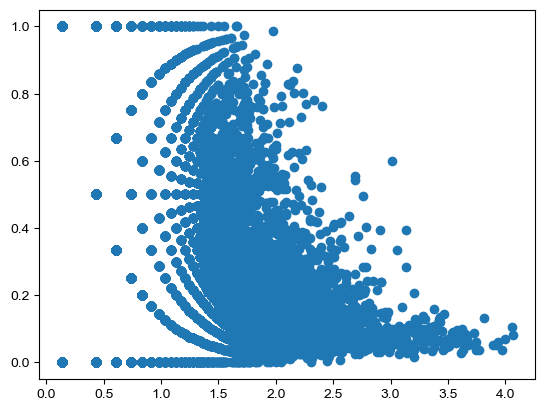

In [98]:
xs = np.log10(df1["TPM"])
ys = df1["NTR"]
plt.scatter(xs, ys)

In [104]:
df1[(df1["Total"] >= 1000) & (df1["NTR"] >= 0.2)].sort_values(by="Total", ascending=False)

,GeneID,Total,Nascent,TPM,NTR,Halflife,T,DecayRate,SynthesisRate,TranscriptID,TranscriptType,GeneType,GeneName,Chrom,Start,End,Strand,Canonical,Length
13582,ENSG00000173812.11,1174.0,244.0,1594.036619,0.207836,8.925124,8.925124,0.077662,1.237968,ENST00000469257.2,protein_coding,protein_coding,EIF1,chr17,41688884,41692668,+,True,3784
16026,ENSG00000185651.15,1008.0,287.0,1368.644729,0.284722,6.205726,6.205726,0.111695,1.528705,ENST00000342192.9,protein_coding,protein_coding,UBE2L3,chr22,21567713,21624034,+,True,56321
16038,ENSG00000185686.18,1002.0,395.0,1360.498035,0.394212,4.148723,4.148723,0.167075,2.273050,ENST00000398743.6,protein_coding,protein_coding,PRAME,chr22,22547700,22559340,-,True,11640


# Make BED and BAM for gene (YTHDF2)

In [108]:
gene = "YTHDF2"
tids = ["ENST00000542507.5", "ENST00000373812.8", "ENST00000541996.5"]

gene = "GAPDH2"
tids = ["ENST00000229239.10"]

In [109]:
outdir = "results/%s" % gene
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [110]:
with BedFile("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.transcripts.bed.gz") as f:
    transcripts = {t.name: t for t in f}
ts = [transcripts[tid] for tid in tids]
with open(outdir + "/transcripts.%s.bed" % gene, "w+") as fw:
    for t in sorted(ts):
        fw.write(t.format("BED") + "\n")

In [111]:
chrom = ts[0].chrom
start = min([t.start for t in ts])
end = max([t.end for t in ts])

In [112]:
introns_list = []
for t in ts:
    introns = tuple([(x, y) for x, y in BlockTools.gaps(t.blocks)])
    print(introns)
    introns_list.append(introns)

((6534569, 6534809), (6534861, 6536493), (6536593, 6536683), (6536790, 6536919), (6537010, 6537100), (6537216, 6537308), (6537390, 6537583), (6537996, 6538100))


In [113]:
d = pd.read_csv("../../1_FLAIRseq/reports/FLAIRseq_Summary.tsv", sep="\t")
d1 = d[(d["Group"] == "K562") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna())]
d2 = d[(d["Group"] == "K562") & (d["s4U"] == 50) & (d["Time"] == 3) & (d["ActD"].isna())]
print("Cells (0 uM, 3 h): %d" % len(d1))
print("Cells (50 uM, 3 h): %d" % len(d2))

Cells (0 uM, 3 h): 199
Cells (50 uM, 3 h): 189


In [126]:
for d3 in [d1, d2]:
    if d3 is d1:
        bamfile1 = outdir + "/reads.%s.0uM3h.bam" % gene
        bamfile2 = outdir + "/reads.%s.0uM3h.sorted.bam" % gene
        need_nascent = False
    else:
        bamfile1 = outdir + "/reads.%s.50uM3h.bam" % gene
        bamfile2 = outdir + "/reads.%s.50uM3h.sorted.bam" % gene
        need_nascent = True
    
    fw = None
    umi_i = 0
    max_umi = 5
    min_tc = 3
    for cell in d3["Cell"]:
        path = "../../1_FLAIRseq/results/mapping/mark_duplicate/%s/%s.bam" % (cell.split(".")[0], cell)
        path2 = "../../1_FLAIRseq/results/mismatch/ratio_consensus/%s/%s.events.tsv" % (cell.split(".")[0], cell)
        if need_nascent:
            events = pd.read_csv(path2, sep="\t")
            tc_dict = {name: tc for name, tc in events[["Name", "T-C"]].values}
        with BamFile(path, random=True) as f:
            if fw is None:
                fw = BamFile(bamfile1, "wb", f)
            alignments = defaultdict(list)
            for a in f.fetch(chrom, start, end):
                alignments[a.segment.get_tag("CN")].append(a)
            for k, v in alignments.items():
                v1 = []
                for a in v:
                    introns = tuple([(x, y) for x, y in BlockTools.gaps(a.blocks)])
                    if introns in introns_list and abs(a.start - start) < 3 and abs(a.end - end) < 3:
                        v1.append(a)
                v = v1
                
                if len(v) < 3:
                    continue
                if need_nascent and tc_dict[k] < min_tc:
                    continue
                v = v[:min(len(v), 3)]
                introns = tuple([(x, y) for x, y in BlockTools.gaps(v[0].blocks)])
                if introns in introns_list:
                    for a in v:
                        a.segment.set_tag("CN", "UMI.%d" % umi_i)
                        fw.write(a)
                    umi_i += 1
                    if umi_i >= max_umi:
                        break
        if umi_i >= max_umi:
            break
    if fw:
        fw.close()
    
    cmd1 = "samtools sort -o %s %s" % (bamfile2, bamfile1)
    cmd2 = "samtools index %s" % bamfile2
    assert os.system(cmd1) == 0
    assert os.system(cmd2) == 0

    os.remove(bamfile1)

[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R3/20220719_K562R3.C01.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R4/20220719_K562R4.C01.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R4/20220719_K562R4.C02.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R4/20220719_K562R4.C03.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R4/20220719_K562R4.C04.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1_FLAIRseq/results/mapping/mark_duplicate/20220719_K562R4/20220719_K562R4.C05.bam.bai
[W::hts_idx_load3] The index file is older than the data file: ../../1

In [105]:
chrom, start, end

('chr1', 28736620, 28769775)

In [107]:
df1[df1["GeneName"] == "GAPDH"]

,GeneID,Total,Nascent,TPM,NTR,Halflife,T,DecayRate,SynthesisRate,TranscriptID,TranscriptType,GeneType,GeneName,Chrom,Start,End,Strand,Canonical,Length
3914,ENSG00000111640.15,3967.0,344.0,5386.323057,0.086715,22.924634,22.924634,0.030236,1.628604,ENST00000229239.10,protein_coding,protein_coding,GAPDH,chr12,6534516,6538371,+,True,3855
